In [34]:
import numpy as np
import load_mnist
import timeit
import time
import matplotlib.pyplot as plt
from numpy import linalg as LA
import random
import math

In [2]:
def load_data(add_row_of_ones = False):
    '''
    This function loads the mnist train and test data and makes sure each pixel is in
    the range of [0,255]
    
    Each image is represented as a column vector
    '''
    # Loading Data where each each pixel is in range [0, 255]
    X, X_labels, Y, Y_labels = load_mnist.main()
    X_labels = X_labels[:,0]
    Y_labels = Y_labels[:,0]
    
    # Checking if data was loaded properly
    assert X.shape[0] == X_labels.shape[0]
    assert Y.shape[0] == Y_labels.shape[0]
    assert Y.shape[1] == X.shape[1]
    assert (X_labels.ndim == 1) and (Y_labels.ndim == 1)
    assert (np.max(X) <= 255) and (np.min(X) >= 0)
    assert (np.max(Y) <= 255) and (np.min(Y) >= 0)
    assert isinstance(add_row_of_ones, bool)

    X = X.T
    Y = Y.T
    nTrain = X.shape[1]
    nTest = Y.shape[1]
    
    if(add_row_of_ones==True):
        X = np.vstack((X,np.ones(nTrain)))
        Y = np.vstack((Y,np.ones(nTest)))
    
    return X, X_labels, Y, Y_labels, nTrain, nTest

def reset_pixel_range(X):
    '''
    This function resets pixel range from [0,255] to [-1,1]
    '''
    X_new = (X/255)*2 - 1
    return X_new

def get_one_hot_encoding_labels(label, C):
    '''
    This function converts normal labels to one hot encoded labels
    '''
    assert label.ndim == 1, 'labels should be a 1D array'
    assert label.shape[0] > 0
    assert isinstance(C,int) and C > 0
    num_examples = label.shape[0]
    label_ohe = np.zeros((C,num_examples))
    for i in range(0,num_examples):
        label_ohe[label[i],i] = 1
    return label_ohe

def create_train_and_validation_set(X, tX, nTrain, percent_validation=0.1):
    '''
    Separates a dataset into train and validation sets
    '''
    assert isinstance(nTrain, int) and nTrain > 0
    assert X.shape[1] == nTrain
    assert isinstance(percent_validation, int) or isinstance(percent_validation, float)
    assert 0 <= percent_validation <= 1
    assert tX.shape[0] > 0, 'labels should be a 1D array'
    assert tX.shape[1] == nTrain
    
    samplesIndex = random.sample(range(0,nTrain), nTrain) #random sampling n indexes
    num_train = int(np.floor(nTrain*(1-percent_validation))) #number of data used for training
    num_val = int(nTrain - num_train) #number of data used for validation
    assert (num_train+num_val) == nTrain
    
    indices_train = samplesIndex[0:num_train]
    indices_val = samplesIndex[num_train:num_train+num_val]
    
    X_train = X[:,indices_train]
    X_val = X[:,indices_val]
    tX_train = tX[:,indices_train]
    tX_val = tX[:,indices_val]
    
    return X_train, X_val, tX_train, tX_val, num_train, num_val

def initialize_W_b(num_nodes, L, mean=0, sigma=1e-3):
    '''
    Initializes weight matrix for L layered neural network.
    It returns a dictionary where the key is layer number and value is the 2D weight matrix
    '''
    assert isinstance(num_nodes, list) and bool(num_nodes)
    assert isinstance(L, int) and L>0
    assert isinstance(mean, int) or isinstance(mean, float)
    assert isinstance(sigma, int) or isinstance(sigma, float)
    assert len(num_nodes)-1 == L, 'Number of layers and nodes mismatch'
    for n in num_nodes:
        assert isinstance(n,int) and n>0, 'Number of nodes has to be type int and >0'
    W = {}; b = {}
    for l in range(0,L):
        l = int(l)
        dim1 = num_nodes[l] #number of nodes in layer 1
        dim2 = num_nodes[l+1] #number of nodes in layer 1+1
        W[l+1] = np.random.normal(loc=0.0, scale=1e-3, size=(dim2,dim1)) #size(dim2,dim1)
        b[l+1] = np.random.normal(loc=0.0, scale=1e-3, size = (dim2)) #size(dim2,)
    return W, b

def update_neta(neta_0, ep, T):
    '''
    This function updates the learning rate (neta) using an annealing procedure
    '''
    assert isinstance(neta_0, float) or isinstance(neta_0, int)
    assert neta_0 > 0
    assert isinstance(ep,int)
    assert isinstance(T, float) or isinstance(T, int)
    
    neta_new = neta_0/(1 + ep/T)
    return neta_new


def get_accuracy_and_risk(X, W, b, tX, num_nodes, L):
    '''
    This function calculates the accuracy and risk
    '''
    assert isinstance(L, int) and L>0
    assert isinstance(num_nodes, list) and (len(num_nodes) == L+1)
    assert isinstance(X, np.ndarray)
    assert isinstance(W, dict) and (len(W) == L)
    assert X.shape[1] > 0

    num = X.shape[1] #number of examples
    C = num_nodes[-1]
    alpha, z = feed_forward(X, W, b, num_nodes, L)
    y = alpha[L] #size (C,num)
    
    assert tX.shape == y.shape
    assert y.shape[0] == num_nodes[-1]
    
    pred = np.argmax(y, axis=0)
    actual = np.argmax(tX, axis=0)
    
    acc_vec = pred == actual
    acc = np.sum(acc_vec)/num
    
    loss = np.sum( (-tX * np.log(y)), axis=0)/C
    risk = np.sum(loss)/num
    
    return acc, risk

def plot_accuracy_and_risk(accuracy_train, accuracy_val, risk_train, risk_val):
    fig, axs = plt.subplots(1,2, figsize=(16, 5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .4, wspace=.2)
    axs = axs.ravel()

    axs[0].plot(accuracy_train, 'r', label='Train')
    axs[0].plot(accuracy_val, 'b', label='Validation')
    axs[0].set_title('Accuracy vs epocs'); axs[0].legend()
    axs[1].plot(risk_train, 'r', label='Train')
    axs[1].plot(risk_val, 'b', label='Validation')
    axs[1].set_title('Risk vs epocs'); axs[1].legend()
    
    return None

def plot_weights_layer1(W):
    assert isinstance(W, np.ndarray)
    
    fig, axs = plt.subplots(8,8, figsize=(18, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .4, wspace=.01)
    axs = axs.ravel()
    
    for i in range(0,64):
        axs[i].imshow(W[i,:].reshape(28,28), cmap='gray')
        axs[i].set_title('w_{0}'.format(i))

    return None

def plot_weights_layer2(W):
    assert isinstance(W, np.ndarray)
    
    fig, axs = plt.subplots(2,5, figsize=(18, 8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .4, wspace=.01)
    axs = axs.ravel()
    
    for i in range(0,10):
        axs[i].imshow(W[i,:].reshape(8,8), cmap='gray')
        axs[i].set_title('w_{0}'.format(i))

    return None

def get_rho(z, dim): #softmax function
    '''
    Computes softmax of z, where each column in z is an example.
    '''
    assert z.ndim == 2, 'z must be 2D ndarray'
    assert isinstance(dim,int) and dim>0
    assert z.shape[0] == dim, 'number of rows in z must be equal to number of classes C'
    assert z.shape[1] > 0, 'Number of columns cannot be zero'

    n = z.shape[1]
    z = z - np.max(z, axis=0) #softmax trick for numerical stability
    exp_z = np.exp(z) #size (dimxn)
    assert exp_z.shape == z.shape
    
    denom = np.sum(exp_z, axis=0) #size (n,)
    assert denom.shape[0] == n, 'Invalid number of denominators'
    
    y = exp_z/denom
    assert (z.shape == y.shape), 'You fucked up bruh. Check.'
    
    return y

def get_phi(z, dim): #sigmoid function
    '''
    Computes the element wise sigmoid of 2D array z
    
    Each column of z represents an example
    The number of rows represents number of nodes in hidden layer
    '''
    assert isinstance(z, np.ndarray), 'z must be an ndarray'
    assert z.ndim == 2, 'z must be 2D ndarray'
    assert isinstance(dim,int) and dim>0
    assert z.shape[0] == dim, 'z size should be = (dim, batch_size)'

    y = 1/(1+np.exp(-z)) #element wise sigmoid
    
    assert y.shape == z.shape
    return y

def h(X):
    '''
    Inserts a row of ones at the bottom of X
    '''
    assert isinstance(X, np.ndarray)
    assert X.ndim == 2
    
    Ones = np.ones((X.shape[1]))
    Y = np.vstack((X,Ones))
    
    return Y

def get_A(W,b):
    '''
    Returns the A matrix by adding a column of b to W
    '''
    assert isinstance(W,np.ndarray)
    assert isinstance(b,np.ndarray)
    
    b = b.reshape(-1,1)
    A = np.hstack((W, b)) #adding the bias column to the right end of W
    
    assert A.shape[1] == W.shape[1]+1, 'Column not added properly'
    assert A.shape[0] == W.shape[0]
    
    return A

def get_W_b(A):
    '''
    Extracts the W matrix and bias vector from A and returns them
    '''
    assert isinstance(A, np.ndarray)
    
    W = A[:,0:-1] #everything except the last column
    b = A[:,-1] #last column of A
    
    assert A.shape[1] == W.shape[1]+1, 'Column not added properly'
    assert A.shape[0] == W.shape[0]
    assert b.ndim == 1 and b.shape[0] == W.shape[0], 'bias needs to be a 1D vector'

    return W, b

def feed_forward(X, W, b, num_nodes, L):
    '''
    Implements feed forward step of L layered neural network.
    It uses a sigmoid nonlinearity for all hidden layers and softmax for final.
    
    It returns a dictionary where keys are layer numbers and values are activations of those layers.
    eg - a[1] = activation of first hidden layer
         a[0] = input
    '''
    assert isinstance(W,dict) and len(W) > 0
    assert isinstance(b,dict) and len(b) > 0
    assert isinstance(X,np.ndarray)
    assert isinstance(L,int) and L > 0
    assert (X.shape[0]) == W[1].shape[1], 'Input dimension not compatible with weight matrix'
    assert len(num_nodes)-1 == L
    assert len(W) == L
    
    alpha = {}; alpha[0] = h(X)
    A = {}; A[0] = None
    z = {}; z[0] = None
    
    for l in range(1,L+1):
        dim = num_nodes[l]
        A[l] = get_A(W[l],b[l])
        z[l] = A[l] @ alpha[l-1]
        assert not(np.any(np.isnan(A[l]))), 'Nan encountered in A in layer {0}'.format(l)
        assert not(np.any(np.isnan(z[l]))), 'Nan encountered in z in layer {0}'.format(l)
        if (l == L): #at output, we use softmax
            alpha[l] = get_rho(z[l], dim)
        else:
            alpha[l] = h(get_phi(z[l], dim))
    assert len(alpha) == L+1, 'Number of activations not equal to number of layers'
    return alpha, z


def get_delta_L(z, tX, dim, L):
    '''
    Computes delta of the final layer which has softmax
    '''
    assert isinstance(dim, int) and dim > 0
    assert isinstance(z, np.ndarray) and z.shape[0] == dim
    assert isinstance(tX, np.ndarray)
    assert tX.shape == z.shape

    rho_z = get_rho(z, dim)
    y = get_rho(z,dim)
    pi_x_theta = y - tX
    delta_L = pi_x_theta * (rho_z * (1-rho_z))
    assert delta_L.shape == rho_z.shape
    return delta_L

def backprop(alpha, z, W, b, tX, neta, num_nodes, L):
    '''
    Computes gradients and implements backpropagation using gradient descent with cross entropy loss
    '''
    assert isinstance(z,dict) and len(z) > 0
    assert isinstance(W,dict) and len(W) > 0
    assert isinstance(L,int) and L > 0
    assert isinstance(num_nodes, list)
    assert isinstance(alpha, dict) and len(alpha) == len(num_nodes)
    assert isinstance(tX, np.ndarray)
    assert isinstance(neta, int) or isinstance(neta,float)
    assert len(num_nodes)-1 == L
    assert len(W) == L
    
    delta = {} #initializing delta as a dictionary
    gradient = {} #initializing gradient as a dictionary
    gradient[0] = None
    n = tX.shape[1]
    A = {}; A[0] = None
    
    for l in range(L,0,-1):
        dim = num_nodes[l]
        if(l==L): #at output
            delta[l] = get_delta_L(z[l], tX, dim, L)
        else:
            phi_z = get_phi(z[l], dim)
            delta[l] = (W[l+1].T @ delta[l+1]) * (phi_z * (1-phi_z))
        assert not(np.any(np.isnan(delta[l]))), 'Nan encountered in layer {0}'.format(l)
        
        gradient[l] = delta[l] @ (alpha[l-1].T)
        A[l] = get_A(W[l], b[l])
        A[l] = A[l] - (neta*gradient[l])
        
        W[l], b[l] = get_W_b(A[l])

    return W, b, gradient

In [3]:
# Loading Data where each each pixel is in range [0, 255]
X, X_labels, Y, Y_labels, nTrain, nTest = load_data(add_row_of_ones = False)
# Dimension of each input and number of classes
dim = X.shape[0]
C = 10

# Formatting data
X = reset_pixel_range(X)
Y = reset_pixel_range(Y)
tX = get_one_hot_encoding_labels(X_labels, C)
tY = get_one_hot_encoding_labels(Y_labels, C)

# Creating training and validation set
X_train, X_val, tX_train, tX_val, num_train, num_val = create_train_and_validation_set(X, tX, nTrain, percent_validation=0.1)

# Training: 2 layered fully connected network

In [61]:
# Network architecture
num_nodes = [dim, 64, 10]
L = len(num_nodes) - 1
neta_0 = 1e-2
T = 8
num_epochs = 64
batch_size = 128
nTrain = X_train.shape[1]
num_batches = int(np.ceil(nTrain/batch_size)) #upper bound on number of batches


# Matrix initialization
accuracy_train = np.zeros((num_epochs))
accuracy_val = np.zeros((num_epochs))
risk_train = np.zeros((num_epochs))
risk_val = np.zeros((num_epochs))
accuracy_train_batch = []
risk_train_batch = []

In [62]:
# Training starts
W, bias = initialize_W_b(num_nodes, L, mean=0, sigma=1e-3)
for ep in range(0, num_epochs):
    # Shuffling training data at the start of each epoch
    samplesIndex = random.sample(range(0,nTrain), nTrain)
    X_train = X_train[:,samplesIndex]
    tX_train = tX_train[:,samplesIndex]
    
    neta = update_neta(neta_0, ep, T)
    
    for b in range(0,num_batches):
        # Create batch
        try:
            X_train_batch = X_train[:,b*batch_size:(b+1)*batch_size]
            tX_train_batch = tX_train[:,b*batch_size:(b+1)*batch_size]
        except IndexError:
            X_train_batch = X_train[:,b*batch_size:nTrain]
            tX_train_batch = tX_train[:,b*batch_size:nTrain]
        # Feed Forward
        alpha, z = feed_forward(X_train_batch, W, bias, num_nodes, L)
        # Weight update (gradient descent with an annealing learning rate)
        W, bias, _ = backprop(alpha, z, W, bias, tX_train_batch, neta, num_nodes, L)
        # Accuracy and risk per sgd iteration
        accuracy_temp, risk_temp = get_accuracy_and_risk(X_train_batch, W, bias, tX_train_batch, num_nodes, L)
        accuracy_train_batch.append(accuracy_temp)
        risk_train_batch.append(risk_temp)

    # Accuracy and Risk per epoch
    accuracy_train[ep], risk_train[ep] = get_accuracy_and_risk(X_train, W, bias, tX_train, num_nodes, L)
    accuracy_val[ep], risk_val[ep] = get_accuracy_and_risk(X_val, W, bias, tX_val, num_nodes, L)


# Plotting accuracy and risk per epoch

Final train accuracy = 0.9526481481481481
Final validation accuracy = 0.941
Testing accuracy = 0.9386


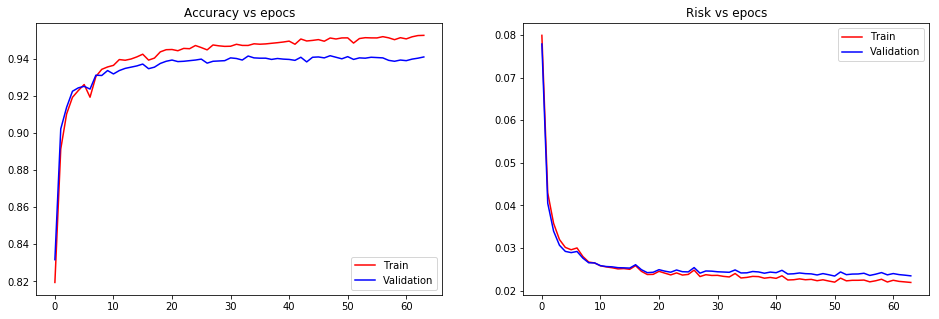

In [63]:
print('Final train accuracy = {0}'.format(accuracy_train[-1]))
print('Final validation accuracy = {0}'.format(accuracy_val[-1]))
plot_accuracy_and_risk(accuracy_train, accuracy_val, risk_train, risk_val)
# Testing
accuracy_test, risk_test = get_accuracy_and_risk(Y, W, bias, tY, num_nodes, L)
print('Testing accuracy = {0}'.format(accuracy_test))

# Plotting accuracy and risk per iteration of SGD

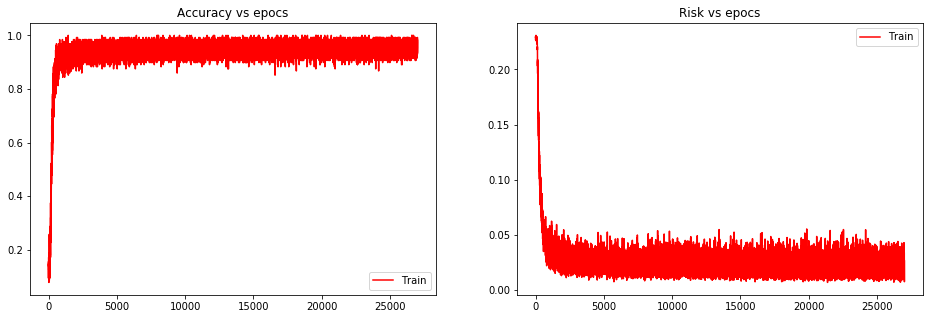

In [64]:
fig, axs = plt.subplots(1,2, figsize=(16, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.2)
axs = axs.ravel()

axs[0].plot(accuracy_train_batch, 'r', label='Train')
axs[0].set_title('Accuracy vs epocs'); axs[0].legend()
axs[1].plot(risk_train_batch, 'r', label='Train')
axs[1].set_title('Risk vs epocs'); axs[1].legend()

In [ ]:
# plot_weights_layer1(W[1])
# plot_weights_layer2(W[2])

# Gradient check for layer weights

In [74]:
# Selecting a single example
x = X_train[:,100].reshape(-1,1)
tx = tX_train[:,100].reshape(-1,1)
W, bias = initialize_W_b(num_nodes, L, mean=0, sigma=1e-3)
# Feed Forward
alpha, z = feed_forward(x, W, bias, num_nodes, L)
# Gradient using backprop
_, _, gradient = backprop(alpha, z, W, bias, tx, neta_0, num_nodes, L)

# ----------- By plugging in different values for a,b,l, we can check the gradient ----------- 

a, b = 10, 20 #index of weight matrix to perturb with epsilon
l = 1 #layer number
epsilon_values = [0.05, 0.06, 0.07, 0.08, 0.09]
error = []
for epsilon in epsilon_values:
    W[l][a,b] += epsilon
    alpha1, _ = feed_forward(x, W, bias, num_nodes, L)
    y1 = np.log(alpha1[2]) #predicted label
    loss1 = np.sum( (-tx*y1))
    
    W[l][a,b] -= (2*epsilon)
    alpha2, _ = feed_forward(x, W, bias, num_nodes, L)
    W[l][a,b] += epsilon
    y2 = np.log(alpha2[2]) #predicted label
    loss2 = np.sum( (-tx*y2))
    
    # Calculating numeric gradient
    numeric_gradient = (loss1 - loss2)/(2*epsilon)
    # Calculating error in gradient
    error.append(np.abs(numeric_gradient - gradient[l][a,b]))

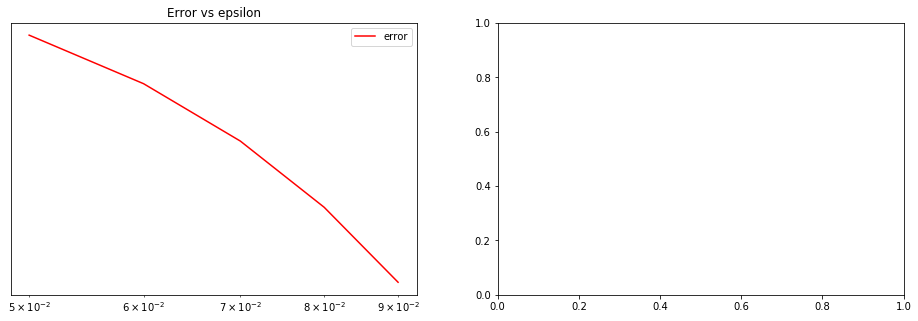

In [75]:
# Plotting error vs epsilon 
fig, axs = plt.subplots(1,2, figsize=(16, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.2)
axs = axs.ravel()

axs[0].plot(epsilon_values, error, 'r', label='error')
axs[0].set_title('Error vs epsilon'); axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xscale('log')

# Gradient check for layer biases

In [85]:
# Selecting a single example
x = X_train[:,100].reshape(-1,1)
tx = tX_train[:,100].reshape(-1,1)
W, bias = initialize_W_b(num_nodes, L, mean=0, sigma=1e-3)
# Feed Forward
alpha, z = feed_forward(x, W, bias, num_nodes, L)
# Gradient using backprop
_, _, gradient = backprop(alpha, z, W, bias, tx, neta_0, num_nodes, L)

# ----------- By plugging in different values for a,b,l, we can check the gradient ----------- 

a = 20 #index of bias vector to perturb with epsilon
l = 1 #layer number
epsilon_values = [0.05, 0.06, 0.07, 0.08, 0.09]
error = []
for epsilon in epsilon_values:
    bias[l][a] += epsilon
    alpha1, _ = feed_forward(x, W, bias, num_nodes, L)
    y1 = np.log(alpha1[2]) #predicted label
    loss1 = np.sum( (-tx*y1))
    
    bias[l][a] -= (2*epsilon)
    alpha2, _ = feed_forward(x, W, bias, num_nodes, L)
    bias[l][a] += epsilon 
    y2 = np.log(alpha2[2]) #predicted label
    loss2 = np.sum( (-tx*y2))
    
    # Calculating numeric gradient
    numeric_gradient = (loss1 - loss2)/(2*epsilon)
    # Calculating error in gradient
    error.append(np.abs(numeric_gradient - gradient[l][a,b]))

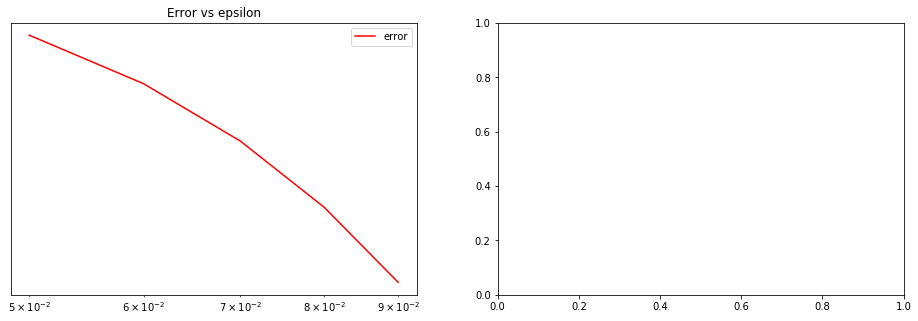

In [86]:
# Plotting error vs epsilon 
fig, axs = plt.subplots(1,2, figsize=(16, 5), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.2)
axs = axs.ravel()

axs[0].plot(epsilon_values, error, 'r', label='error')
axs[0].set_title('Error vs epsilon'); axs[0].legend()
axs[0].set_yscale('log')
axs[0].set_xscale('log')